#### Jake Bova
Ch6 hw 1, 8, 9 (no f), 11

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
# !pip install l0bnb
from l0bnb import fit_path # fit_path is a function that fits the l0bnb model, which is a model that fits a linear model with L0 regularization

from sklearn.feature_selection import SequentialFeatureSelector as SFS

### 1
We perform best subset, forward stepwise, and backward stepwise
selection on a single data set. For each approach, we obtain p + 1
models, containing 0, 1, 2, . . . , p predictors. Explain your answers:

- a) Which of the three models with k predictors has the smallest
training RSS?

The model with k predictors that has the smallest training RSS will be the one that used best subset selection. This is because best subset selection considers all possible models with k predictors and selects the best one. Forward and backward stepwise selection do not consider all possible models with k predictors, so they may miss the best model.

- b) Which of the three models with k predictors has the smallest test RSS?

Best subset selection would most likely have the smallest test RSS. This is because best subset selection considers all possible models with k predictors and selects the best one. Forward and backward stepwise selection do not consider all possible models, however they may still find the best model by chance.

- c) True or False:

- - i. The predictors in the k-variable model identified by forward
stepwise are a subset of the predictors in the (k +1)-variable
model identified by forward stepwise selection.

True.  The model with k+1 is an augmented version of the model with k predictors.

- - ii. The predictors in the k-variable model identified by back-
ward stepwise are a subset of the predictors in the (k + 1)-
variable model identified by backward stepwise selection.

True.  The model with k is created by removing a predictor from the model with k+1 predictors.

- - iii. The predictors in the k-variable model identified by back-
ward stepwise are a subset of the predictors in the (k + 1)-
variable model identified by forward stepwise selection.

False.  There is no connection here.

- - iv. The predictors in the k-variable model identified by forward
stepwise are a subset of the predictors in the (k +1)-variable
model identified by backward stepwise selection.

False. No connection.

- - v. The predictors in the k-variable model identified by best
subset are a subset of the predictors in the (k + 1)-variable
model identified by best subset selection.

False.  The model with k+1 selects from all possible models with k+1 predictors, so it may not be a subset of the model with k predictors (predictors may be added or removed).

### 8
In this exercise, we will generate simulated data, and will then use
this data to perform forward and backward stepwise selection.

- a) Create a random number generator and use its normal() method
to generate a predictor X of length n = 100, as well as a noise
vector " of length n = 100.

In [2]:
def numGen(n):
    np.random.seed(42)
    return np.random.normal(size=n)

n = 100
X = numGen(n)
noise = numGen(n)

- b) Generate a response vector Y of length n = 100 according to the model
$$
Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon
$$ ,
where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice.

In [3]:
beta = np.array([3, 4, 3, 2])
Y = beta[0] + beta[1]*X + beta[2]*X**2 + beta[3]*X**3 + noise

/tmp/ipykernel_22045/1526155891.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


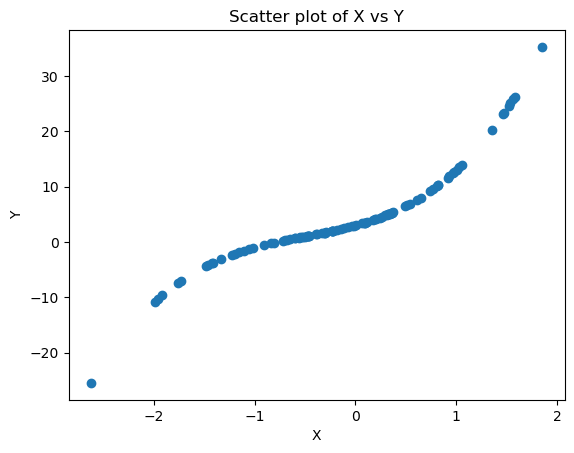

In [4]:
# plot the data
fig, ax = subplots()
ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter plot of X vs Y')
fig.show()

- c) Use forward stepwise selection to select a model containing the predictors $X, X^2, ... , X^{10}$. What is the model obtained according to $C_p$? Report the coeffecients of the model obtained.

In [5]:
def nCp(sigma2, estimator, X, Y): # negative Cp statistic
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [6]:
# create a dataframe with the predictors and the response
df = pd.DataFrame({'Y': Y})
for i in range(1, 11):
    df[f'X^{i}'] = X**i
# move the response to the last column
df = df[['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10', 'Y']]

design = MS(df.columns.drop('Y')).fit(df) # fit a model spec to the data (MS is a class that represents a model specification, which is a set of features)
Yc = np.array(df['Y']) # the response variable
Xc = design.transform(df) # the design matrix with predictors
sigma2 = OLS(Yc,Xc).fit().scale # the residual variance of the OLS model, .scale is the residual variance of the OLS model

neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

df_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
df_Cp.fit(df, Yc)
df_Cp.selected_state_

('X^1', 'X^2', 'X^3')

The coefs from forward selection are the ones that were used to generate the data.  The added predictors are not significant, so they are not included in the model.

- d) Repeat (c), using backwards stepwise selection. How does your
answer compare to the results in (c)?

In [7]:
# use SFS for backward selection
# will need linear regression as the estimator

from sklearn.linear_model import LinearRegression

sfs = SFS(LinearRegression(),
            n_features_to_select=3,
            direction='backward',
            scoring=neg_Cp,
            cv=5)

sfs.fit(Xc, Yc)
# get the selected features
# use the boolean array sfs.get_support() to get the selected features from Xc
selected_features = Xc.columns[sfs.get_support()]
selected_features

Index(['X^1', 'X^2', 'X^3'], dtype='object')

The coefs from backward selection are the same as the coefs from forward selection. 

- e) Now fit a lasso model to the simulated data, again using $X, X^2, ... , X^{10}$ as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.

optimal lambda (alpha): 0.007870977285052191
non-zero coefficients and their values: 
X^1    4.522824
X^2    3.426460
X^3    5.344180
dtype: float64
intercept: 4.19305560215925


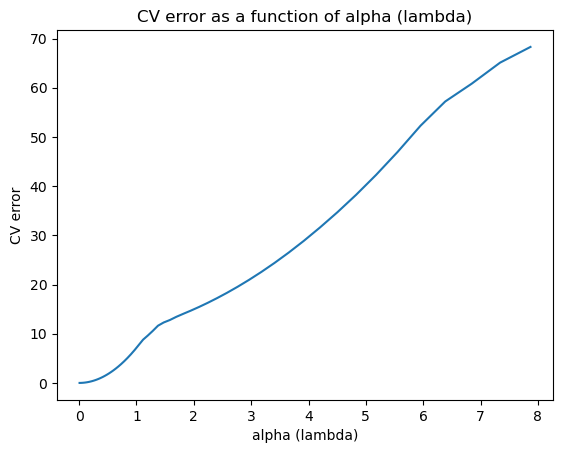

In [8]:
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])

# create a dataframe with the predictors and the response
df = pd.DataFrame({'Y': Y})
for i in range(1, 11):
    df[f'X^{i}'] = X**i
# move the response to the last column
df = df[['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10', 'Y']]

pipeCV.fit(df.drop(columns=['Y']), df.Y)
tuned_lasso = pipeCV.named_steps['lasso']
print("optimal lambda (alpha): {}".format(tuned_lasso.alpha_))
# get coef names from df using tuned_lasso.coef_
coef_names = df.drop(columns=['Y']).columns
# get the non-zero coefficients
non_zero_coef = coef_names[tuned_lasso.coef_ != 0]
print("non-zero coefficients and their values: \n{}".format(pd.Series(tuned_lasso.coef_[tuned_lasso.coef_ != 0], index=non_zero_coef)))
# intercept
print("intercept: {}".format(tuned_lasso.intercept_))

# create plot of the CV error as a function of alpha
fig, ax = subplots()
ax.plot(tuned_lasso.alphas_, tuned_lasso.mse_path_.mean(axis=1))
# ax.set_xscale('log')
ax.set_xlabel('alpha (lambda)')
ax.set_ylabel('CV error')
ax.set_title('CV error as a function of alpha (lambda)');

- f) Now generate a response vector Y according to the model
$$
Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon
$$
and perform stepwise selection and the lasso. Discuss the results obtained.

In [9]:
# create new reponse vector using results from lasso
b0 = tuned_lasso.intercept_
b1 = tuned_lasso.coef_[0]
b2 = tuned_lasso.coef_[1]
b3 = tuned_lasso.coef_[2]

Y_lasso = b0 + b1*X + b2*X**2 + b3*X**3 + noise

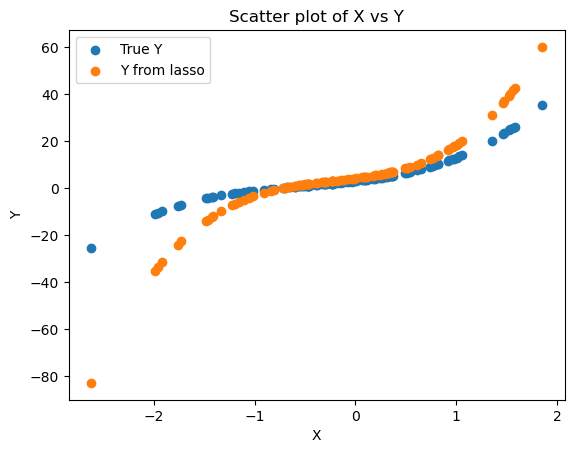

In [10]:
# plot the data
fig, ax = subplots()
ax.scatter(X, Y, label='True Y')
ax.scatter(X, Y_lasso, label='Y from lasso')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter plot of X vs Y')
ax.legend()

In [11]:
# perform stepwise selection and lasso
# create a dataframe with the predictors and the response
df = pd.DataFrame({'Y': Y_lasso})
for i in range(1, 4):
    df[f'X^{i}'] = X**i
# move the response to the last column
df = df[['X^1', 'X^2', 'X^3', 'Y']]
design = MS(df.columns.drop('Y')).fit(df) # fit a model spec to the data (MS is a class that represents a model specification, which is a set of features)
Y = np.array(df['Y']) # the response variable
X = design.transform(df) # the design matrix with predictors
sigma2 = OLS(Y,X).fit().scale # the residual variance of the OLS model, .scale is the residual variance of the OLS model

neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design,
                                 direction='forward',
                                 max_terms=len(design.terms))

df_Cp = sklearn_selected(OLS,
                            strategy,
                            scoring=neg_Cp)
df_Cp.fit(df, Y)
df_Cp.selected_state_

('X^1', 'X^2', 'X^3')

### 9
In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [13]:
# load college data
college = load_data('College')
college

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


(a) Split the data set into a training set and a test set.

In [23]:
# train test split
X = college.drop(columns=['Apps'])
Y = college['Apps']
# cast Private to 0 and 1
X['Private'] = X['Private'].map({'Yes': 1, 'No': 0})
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y, test_size=0.2, random_state=42)

(b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [33]:
lm = OLS(Y_train.to_numpy(), X_train.to_numpy()).fit()
Yhat = lm.predict(X_test)
test_error = np.mean((Y_test - Yhat)**2)
print("Test error OLS: {}".format(test_error))
# R^2
R2 = lm.rsquared
print("R^2: {}".format(R2))

Test error OLS: 1494664.5933117634
R^2: 0.9586161124350168


(c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [34]:
alphas = np.logspace(-3, 3, 100)
ridgeCV = skl.RidgeCV(alphas=alphas, cv=5)
ridgeCV.fit(X_train, Y_train)
Yhat = ridgeCV.predict(X_test)
test_error = np.mean((Y_test - Yhat)**2)
print("Test error Ridge: {}".format(test_error))
# R^2
R2 = ridgeCV.score(X_test, Y_test)
print("R^2: {}".format(R2))

Test error Ridge: 1475450.1731708471
R^2: 0.8890363191118873


(d) Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [35]:
lassoCV = skl.LassoCV(n_alphas=100, cv=5)
lassoCV.fit(X_train, Y_train)
Yhat = lassoCV.predict(X_test)
test_error = np.mean((Y_test - Yhat)**2)
print("Test error Lasso: {}".format(test_error))
print("Number of non-zero coefficients: {}".format(np.sum(lassoCV.coef_ != 0)))
# R^2
R2 = lassoCV.score(X_test, Y_test)
print("R^2: {}".format(R2))

Test error Lasso: 1587020.0176529174
Number of non-zero coefficients: 7
R^2: 0.8806455236482635


(e) Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [36]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# fit a linear regression model on the transformed data
lm = OLS(Y_train, X_train_pca).fit()
Yhat = lm.predict(X_test_pca)
test_error = np.mean((Y_test - Yhat)**2)
print("Test error PCR: {}".format(test_error))
# R^2
R2 = lm.rsquared
print("R^2: {}".format(R2))

Test error PCR: 9977075.391008932
R^2: 0.6001928194338894


(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

The best approach based on error appears to be the ridge regression model.  Based on R^2, the best approach is standard linear regression. We cannot very accurtaely predict the number of college applications received.  The test errors are all very similar, with the exception of PCR being much higher.

### 11
We will now try to predict per capita crime rate in the Boston dataset.

In [37]:
# import Boston data
boston = load_data('Boston')
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.

In [54]:
# Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.
X = boston.drop(columns=['crim'])
Y = boston['crim']
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y, test_size=0.2, random_state=42)

# best subset selection
design = MS(X.columns).fit(X)
Y = Y_train.to_numpy()
X = design.transform(X_train)
sigma2 = OLS(Y,X).fit().scale
neg_Cp = partial(nCp, sigma2)
strategy = Stepwise.first_peak(design,
                                 direction='forward',
                                 max_terms=len(design.terms))
df_Cp = sklearn_selected(OLS,
                            strategy,
                            scoring=neg_Cp)
df_Cp.fit(X_train, Y_train)
print("Selected features best subset selection: {}".format(df_Cp.selected_state_))
# test error
Y = Y_test.to_numpy()
X = design.transform(X_test)
Yhat = df_Cp.predict(X_test)
test_error = np.mean((Y - Yhat)**2)
print("Test error best subset selection: {}".format(test_error))
# selected features

# lasso
alphas = np.logspace(-3, 3, 100)
lassoCV = skl.LassoCV(n_alphas=100, cv=5)
lassoCV.fit(X_train, Y_train)
Yhat = lassoCV.predict(X_test)
test_error = np.mean((Y_test - Yhat)**2)
# select non-zero coefficients
non_zero_coef = X_train.columns[lassoCV.coef_ != 0]
print("Selected features Lasso: {}".format(non_zero_coef))
print("Test error Lasso: {}".format(test_error))

# ridge
alphas = np.logspace(-3, 3, 100)
ridgeCV = skl.RidgeCV(alphas=alphas, cv=5)
ridgeCV.fit(X_train, Y_train)
Yhat = ridgeCV.predict(X_test)
test_error = np.mean((Y_test - Yhat)**2)
# selected features
print("Selected features Ridge: {}".format(X_train.columns[abs(ridgeCV.coef_) > 0.05]))
print("Test error Ridge: {}".format(test_error))

# PCR
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# fit a linear regression model on the transformed data
lm = OLS(Y_train, X_train_pca).fit()
Yhat = lm.predict(X_test_pca)
test_error = np.mean((Y_test - Yhat)**2)
print("Test error PCR: {}".format(test_error))
# selected features
print("Selected features PCR: {}".format(X_train.columns[abs(pca.components_[0]) > 0.01]))

Selected features best subset selection: ('dis', 'medv', 'nox', 'ptratio', 'rad', 'zn')
Test error best subset selection: 25.916708095673883
Selected features Lasso: Index(['zn', 'age', 'dis', 'rad', 'tax', 'lstat', 'medv'], dtype='object')
Test error Lasso: 26.763407229661542
Selected features Ridge: Index(['indus', 'rm', 'dis', 'rad', 'ptratio', 'lstat', 'medv'], dtype='object')
Test error Ridge: 25.676539805879067
Test error PCR: 33.65738415899526
Selected features PCR: Index(['zn', 'indus', 'age', 'rad', 'tax', 'lstat', 'medv'], dtype='object')


(b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.

In [6]:
# it appears the ridge regression was the best from above
# Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.
# import Boston data
boston = load_data('Boston')
# Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.
X = boston.drop(columns=['crim'])
Y = boston['crim']
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y, test_size=0.2, random_state=42)

# define model
alphas = np.logspace(-3, 3, 100)
model = skl.RidgeCV(alphas=alphas, cv=5)
# fit model
model.fit(X_train, Y_train)
# predict
Yhat = model.predict(X_test)
# test error
test_error = np.mean((Y_test - Yhat)**2)
print("Test error Ridge: {}".format(test_error))
print("Selected features Ridge: {}".format(X_train.columns[abs(model.coef_) > 0.05]))

Test error Ridge: 25.676539805879067
Selected features Ridge: Index(['indus', 'rm', 'dis', 'rad', 'ptratio', 'lstat', 'medv'], dtype='object')


(c) Does your chosen model involve all of the features in the dataset? Why or why not?

The ridge model did not involve all features.  Technically it did, but their coefficients were shrunk to near zero.  The reason for this is that the model is trying to avoid overfitting by reducing the number of predictors.